In [ ]:
!pip install lightly av

## Setup

In [ ]:
#@title default imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch

%matplotlib inline

In [ ]:
#@title detecting back-end device

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} as default device")

Using cuda as default device


In [ ]:
#@title dataset folder

from google.colab import drive

drive.mount("/gdrive")
gdrive_dir = "/gdrive/MyDrive"
pibic_dir = os.path.join(gdrive_dir, "PIBIC")
ucmerced_dir = os.path.join(pibic_dir, "UCMerced/UCMerced_LandUse/Images")
!ls $ucmerced_dir

Mounted at /gdrive
agricultural	 buildings	   freeway	 mediumresidential  river	       tenniscourt
airplane	 chaparral	   golfcourse	 mobilehomepark     runway
baseballdiamond  denseresidential  harbor	 overpass	    sparseresidential
beach		 forest		   intersection  parkinglot	    storagetanks


## Pre-training

In [ ]:
#@title dataloader

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils
from torch.utils.data import DataLoader
from torchvision import transforms

input_size = 224
batch_size = 64

pretrain_transform = SimCLRTransform(
    input_size=input_size,
    hf_prob=0.75,
    vf_prob=0.75,
    rr_prob=0.65,
    min_scale=0.75,
    cj_prob=0.4,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.15,
    cj_sat=0.15,
)

pretrain_dataset = LightlyDataset(
    input_dir=ucmerced_dir,
    transform=pretrain_transform
)

pretrain_dataloader = DataLoader(
    pretrain_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=utils.IMAGENET_NORMALIZE["mean"],
        std=utils.IMAGENET_NORMALIZE["std"],
    ),
])

test_dataset = LightlyDataset(
    input_dir=ucmerced_dir,
    transform=test_transform,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [ ]:
#@title model architecture

import torch.nn as nn
import torchvision.models as models
import lightly.models.modules.heads as lightly_heads

class PreTrainSimSiam(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet18.children())[:-1])
        self._proj_head = lightly_heads.SimSiamProjectionHead(input_dim=512, hidden_dim=512, output_dim=512)
        self._pred_head = lightly_heads.SimSiamPredictionHead(input_dim=512, hidden_dim=128, output_dim=512)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self._proj_head(f)
        p = self._pred_head(z)
        z = z.detach()
        return z, p

pretrain_model = PreTrainSimSiam()
pretrain_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


PreTrainSimSiam(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
#@title pre-training loop

import math
from lightly.loss import NegativeCosineSimilarity
from torch.optim import SGD

loss_fn = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(
    pretrain_model.parameters(),
    lr=0.00625,
    momentum=0.9,
    weight_decay=5e-4
)

train_avg_loss = 0.0
train_avg_output_std = 0.0

def train_per_epoch():
    global train_avg_loss
    global train_avg_output_std

    pretrain_model.train()

    for (x0, x1), _, _ in pretrain_dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)

        optimizer.zero_grad()

        if torch.cuda.is_available():
            z0, p0 = nn.parallel.data_parallel(pretrain_model, x0)
            z1, p1 = nn.parallel.data_parallel(pretrain_model, x1)
        else:
            z0, p0 = pretrain_model(x0)
            z1, p1 = pretrain_model(x1)

        loss = 0.5 * (loss_fn(z0, p1) + loss_fn(z1, p0))
        loss.backward()

        optimizer.step()

        output = p0.detach()
        output = nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        w = 0.9
        train_avg_loss = w * train_avg_loss + (1 - w) * loss.item()
        train_avg_output_std = w * train_avg_output_std + (1 - w) * output_std.item()

    collapse_level = max(0.0, 1 - math.sqrt(512) * train_avg_output_std)

    return (collapse_level, train_avg_loss)

def validate_per_epoch():
    pretrain_model.eval()

collapse_level_history = []
avg_loss_history = []
def pretrain(epochs, report_interval=5):
    for e in range(epochs):
        collapse_level, avg_loss = train_per_epoch()
        collapse_level_history.append(collapse_level)
        avg_loss_history.append(avg_loss)

        validate_per_epoch()

        if (e + 1) % report_interval == 0:
            print(
                f"epoch {(e + 1):3d}: loss = {avg_loss:.4f} |"
                f" collapse level = {collapse_level:.2f}/1.00"
            )


In [ ]:
#@title pre-train 60 epochs

pretrain(60)

epoch   4: loss = -0.3152 | collapse level = 0.14/1.00
epoch   9: loss = -0.7006 | collapse level = 0.05/1.00
epoch  14: loss = -0.8104 | collapse level = 0.03/1.00
epoch  19: loss = -0.8672 | collapse level = 0.03/1.00
epoch  24: loss = -0.8980 | collapse level = 0.03/1.00
epoch  29: loss = -0.9103 | collapse level = 0.04/1.00
epoch  34: loss = -0.9233 | collapse level = 0.04/1.00
epoch  39: loss = -0.9310 | collapse level = 0.04/1.00
epoch  44: loss = -0.9348 | collapse level = 0.04/1.00
epoch  49: loss = -0.9368 | collapse level = 0.04/1.00
epoch  54: loss = -0.9377 | collapse level = 0.04/1.00
epoch  59: loss = -0.9395 | collapse level = 0.04/1.00


In [ ]:
#@title save model
torch.save(
    pretrain_model.state_dict(),
    os.path.join(pibic_dir, "runs/UCMerced/ucmerced_pretrain_simsiam_last.pth")
)

In [ ]:
#@title load model
pretrain_model.load_state_dict(
    torch.load(os.path.join(pibic_dir, "runs/UCMerced/ucmerced_pretrain_simsiam_last.pth"))
)

<ipython-input-8-411e2f257baa>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(pibic_dir, "runs/UCMerced/ucmerced_pretrain_simsiam_last.pth"))


<All keys matched successfully>

### Testing

#### Similarity plot

In [ ]:
#@title generate embeddings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = []
filenames = []

pretrain_model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(test_dataloader):
        x = x.to(device)

        y = pretrain_model.backbone(x).flatten(start_dim=1)

        embeddings.append(y)
        filenames = filenames + list(fnames)

# from sklearn.random_projection import GaussianRandomProjection

embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# projection = GaussianRandomProjection(n_components=2)
# embeddings_clusters = projection.fit_transform(embeddings)

projection = PCA(n_components=50)
embeddings_2d = projection.fit_transform(embeddings)

clusterizator = TSNE(n_components=2)
embedding_clusters = clusterizator.fit_transform(embeddings_2d)

M = np.max(embedding_clusters, axis=0)
m = np.min(embedding_clusters, axis=0)
embedding_clusters = (embedding_clusters - m) / (M - m)

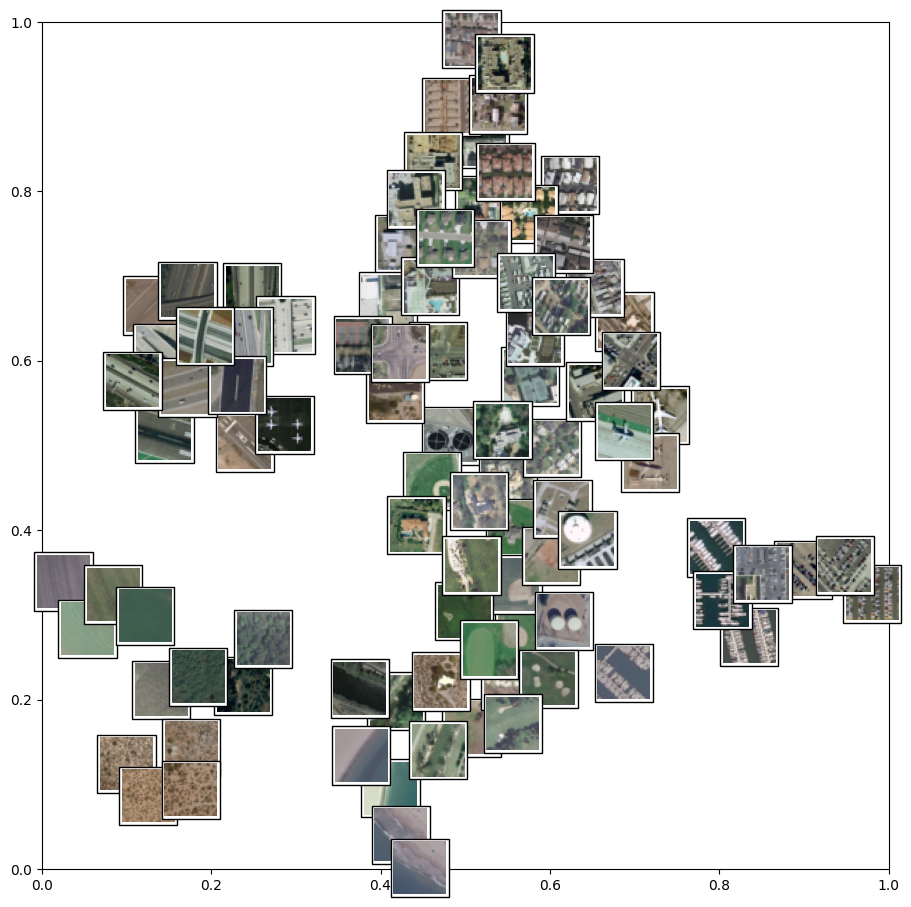

In [ ]:
#@title scatter plot using tumbnails

import torchvision.transforms.functional as functional
from matplotlib import offsetbox
from matplotlib import rcParams
from PIL import Image

fig = plt.figure(figsize=(16, 11))
ax = fig.add_subplot(1, 1, 1)

shown_images_idx = []
shown_images = np.array([[1.0, 1.0]])
iterator = [i for i in range(embedding_clusters.shape[0])]
np.random.shuffle(iterator)
for i in iterator:
    dist = np.sum((embedding_clusters[i] - shown_images) ** 2, 1)
    if np.min(dist) < 2e-3:
        continue
    shown_images = np.r_[shown_images, [embedding_clusters[i]]]
    shown_images_idx.append(i)

for idx in shown_images_idx:
    thumbnail_size = int(rcParams["figure.figsize"][0] * 6.0)
    path = os.path.join(ucmerced_dir, filenames[idx])
    img = Image.open(path)
    img = functional.resize(img, thumbnail_size)
    img = np.array(img)
    img_box = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(img, cmap=plt.cm.gray_r),
        embedding_clusters[idx],
        pad=0.2,
    )
    ax.add_artist(img_box)

ratio = 1.0 / ax.get_data_ratio()
ax.set_aspect(ratio, adjustable="box")

#### KNN plots

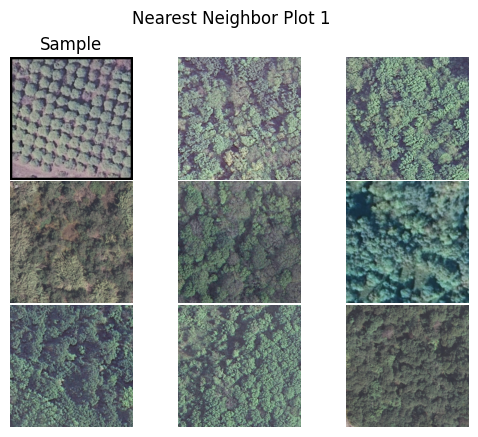

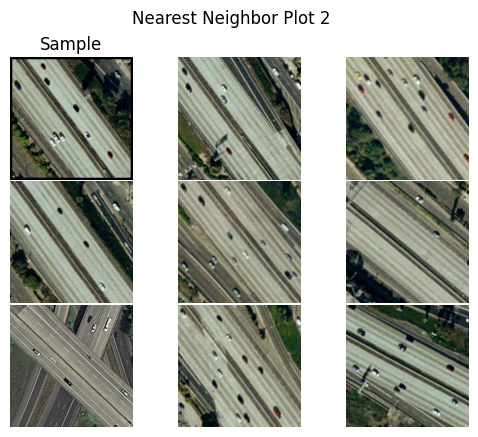

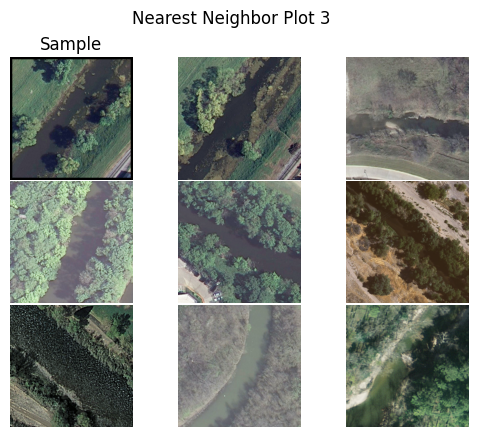

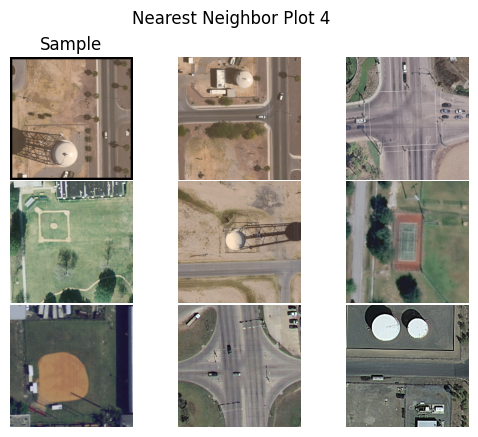

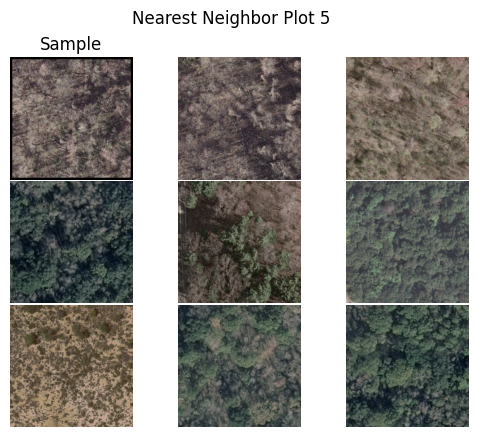

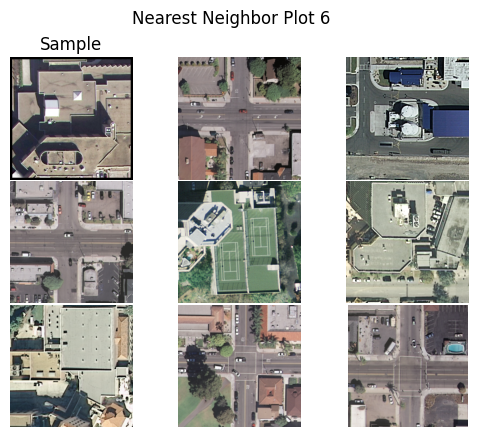

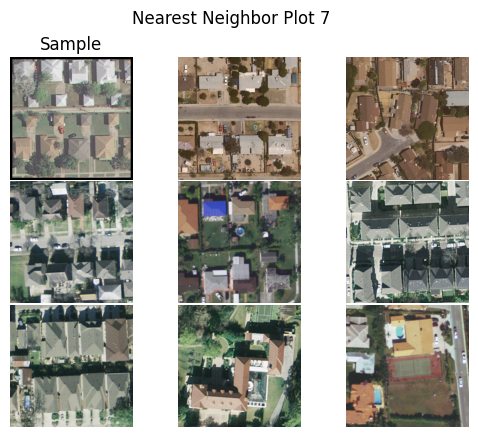

In [ ]:
#@title

sample_images = [
    "agricultural/agricultural04.tif",
    "freeway/freeway03.tif",
    "river/river22.tif",
    "storagetanks/storagetanks83.tif",
    "forest/forest26.tif",
    "buildings/buildings95.tif",
    "mediumresidential/mediumresidential06.tif",
]

def get_image_as_np_array(filename):
    img = Image.open(filename)
    return np.asarray(img)

def get_image_as_np_array_with_frame(filename, w=5):
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image, i):
    n_subplots = 9

    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    example_idx = filenames.index(example_image)
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    fig.subplots_adjust(
        wspace=0.05,
        hspace=0.01
    )
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        fname = os.path.join(ucmerced_dir, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Sample")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))

        plt.axis("off")

for i, sample in enumerate(sample_images):
    plot_nearest_neighbors_3x3(sample, i)

## Fine-tuning

In [ ]:
#@title dataloader

from lightly.transforms import utils
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

input_size = 224
batch_size = 64

finetun_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=utils.IMAGENET_NORMALIZE["mean"],
        std=utils.IMAGENET_NORMALIZE["std"],
    ),
])

dataset = ImageFolder(root=ucmerced_dir, transform=finetun_transform)

validation_split = 0.3
n_data = len(dataset)
n_validation = int(validation_split * n_data)
n_train = n_data - n_validation

_, finetun_test_dataset = random_split(dataset, [n_train, n_validation])
finetun_test_dataloader = DataLoader(
    finetun_test_dataset,
    batch_size=batch_size,
    shuffle=False
)

n_classes = len(dataset.classes)

class FewShotImageFolder(Dataset):
    def __init__(self, root, n_shots, transform=None):
        self.root = root
        self.transform = transform
        self.n_shots = n_shots
        self.classes = sorted(os.listdir(root))
        self.class2idx = { cls: i for i, cls in enumerate(self.classes) }
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root, class_name)
            if not os.path.isdir(class_dir):
                continue
            images_names = os.listdir(class_dir)[:self.n_shots]
            for img_name in images_names:
                image_path = os.path.join(class_dir, img_name)
                item = (image_path, self.class2idx[class_name])
                images.append(item)

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        image = datasets.folder.default_loader(image_path)
        if self.transform:
            image = self.transform(image)

        return image, label


['intersection', 'parkinglot', 'denseresidential', 'mobilehomepark', 'parkinglot', 'river', 'storagetanks', 'intersection', 'golfcourse', 'beach', 'agricultural', 'chaparral', 'overpass', 'agricultural', 'buildings', 'beach', 'storagetanks', 'parkinglot', 'storagetanks', 'river', 'denseresidential', 'beach', 'chaparral', 'baseballdiamond', 'beach', 'storagetanks', 'overpass', 'beach', 'parkinglot', 'agricultural', 'sparseresidential', 'parkinglot', 'mediumresidential', 'parkinglot', 'sparseresidential', 'storagetanks', 'river', 'baseballdiamond', 'denseresidential', 'agricultural', 'chaparral', 'harbor', 'storagetanks', 'sparseresidential', 'mobilehomepark', 'storagetanks', 'river', 'baseballdiamond', 'overpass', 'river', 'forest', 'baseballdiamond', 'intersection', 'freeway', 'denseresidential', 'storagetanks', 'overpass', 'buildings', 'runway', 'river', 'forest', 'airplane', 'agricultural', 'harbor']


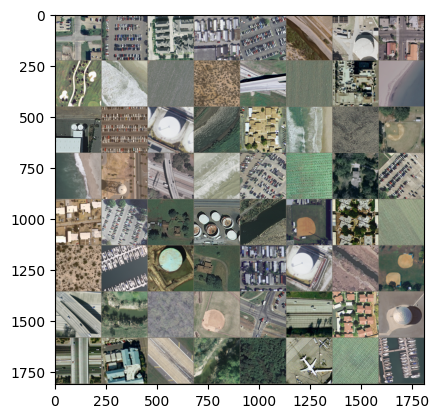

In [ ]:
#@title dataloader sanity check

from torchvision.utils import make_grid

def matplotlib_imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(utils.IMAGENET_NORMALIZE["mean"])
    std = np.array(utils.IMAGENET_NORMALIZE["std"])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def test_dataloader(dataloader):
    iterator = iter(dataloader)
    images, labels = next(iterator)

    img_grid = make_grid(images)
    matplotlib_imshow(img_grid)
    print([dataset.classes[labels[i]] for i in range(batch_size)])
    plt.show()

test_dataloader(finetun_test_dataloader)

In [ ]:
#@title model architecture

import torch.nn as nn
import torch.nn.functional as fn
import torchvision.models as models

class FineTuningSimSiam(nn.Module):
    def __init__(self, resnet18_n1, out_features):
        super().__init__()
        self.backbone = nn.Sequential(*list(resnet18_n1.children()))
        self.imm_fc = nn.Linear(in_features=512, out_features=128)
        self.out_fc = nn.Linear(in_features=128, out_features=out_features)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.imm_fc(x)
        x = fn.relu(x)
        x = self.out_fc(x)
        return x

    def freeze_backbone(self, val=True):
        for param in self.backbone.parameters():
            param.requires_grad = val

finetun_model = FineTuningSimSiam(pretrain_model.backbone, 21)
finetun_model.to(device)

FineTuningSimSiam(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

### Few-shot method

['storagetanks', 'freeway', 'mobilehomepark', 'parkinglot', 'sparseresidential', 'beach', 'chaparral', 'tenniscourt', 'airplane', 'intersection', 'river', 'denseresidential', 'agricultural', 'forest', 'overpass', 'runway', 'buildings', 'baseballdiamond', 'harbor', 'golfcourse', 'mediumresidential']


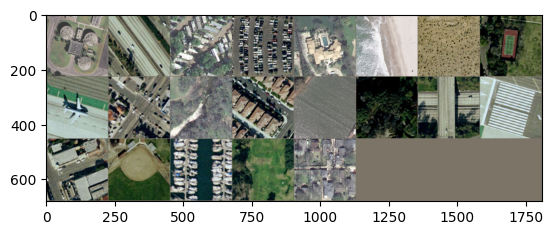

['mobilehomepark', 'runway', 'sparseresidential', 'airplane', 'freeway', 'tenniscourt', 'agricultural', 'tenniscourt', 'overpass', 'harbor', 'beach', 'denseresidential', 'golfcourse', 'baseballdiamond', 'river', 'storagetanks', 'intersection', 'chaparral', 'baseballdiamond', 'buildings', 'runway', 'chaparral', 'mobilehomepark', 'river', 'forest', 'overpass', 'parkinglot', 'denseresidential', 'harbor', 'storagetanks', 'agricultural', 'buildings', 'forest', 'airplane', 'mediumresidential', 'mediumresidential', 'parkinglot', 'intersection', 'beach', 'golfcourse', 'sparseresidential', 'freeway']


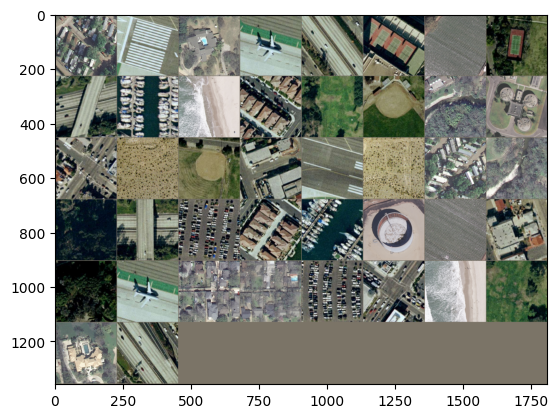

['agricultural', 'tenniscourt', 'chaparral', 'river', 'beach', 'freeway', 'airplane', 'harbor', 'tenniscourt', 'overpass', 'denseresidential', 'river', 'parkinglot', 'beach', 'mediumresidential', 'buildings', 'harbor', 'intersection', 'airplane', 'overpass', 'golfcourse', 'denseresidential', 'intersection', 'parkinglot', 'sparseresidential', 'storagetanks', 'mobilehomepark', 'sparseresidential', 'beach', 'river', 'mediumresidential', 'chaparral', 'runway', 'overpass', 'freeway', 'mediumresidential', 'overpass', 'agricultural', 'airplane', 'forest', 'runway', 'river', 'harbor', 'overpass', 'mediumresidential', 'baseballdiamond', 'runway', 'agricultural', 'golfcourse', 'freeway', 'forest', 'golfcourse', 'runway', 'chaparral', 'sparseresidential', 'buildings', 'intersection', 'chaparral', 'parkinglot', 'freeway', 'denseresidential', 'storagetanks', 'intersection', 'mobilehomepark']


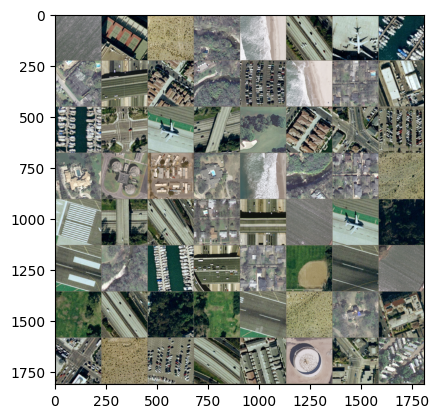

['harbor', 'storagetanks', 'buildings', 'tenniscourt', 'golfcourse', 'agricultural', 'freeway', 'baseballdiamond', 'sparseresidential', 'river', 'agricultural', 'baseballdiamond', 'denseresidential', 'airplane', 'airplane', 'intersection', 'mobilehomepark', 'intersection', 'baseballdiamond', 'intersection', 'mediumresidential', 'chaparral', 'freeway', 'mediumresidential', 'agricultural', 'beach', 'storagetanks', 'golfcourse', 'buildings', 'intersection', 'baseballdiamond', 'baseballdiamond', 'parkinglot', 'golfcourse', 'beach', 'tenniscourt', 'overpass', 'runway', 'harbor', 'intersection', 'agricultural', 'parkinglot', 'parkinglot', 'chaparral', 'runway', 'golfcourse', 'overpass', 'tenniscourt', 'buildings', 'denseresidential', 'airplane', 'storagetanks', 'freeway', 'storagetanks', 'overpass', 'tenniscourt', 'mediumresidential', 'baseballdiamond', 'mobilehomepark', 'beach', 'storagetanks', 'river', 'sparseresidential', 'beach']


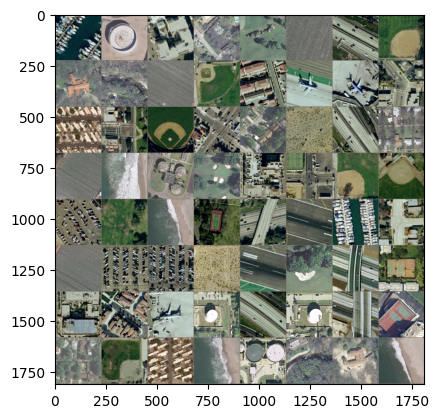

['sparseresidential', 'harbor', 'tenniscourt', 'storagetanks', 'freeway', 'sparseresidential', 'airplane', 'forest', 'airplane', 'airplane', 'intersection', 'forest', 'parkinglot', 'overpass', 'chaparral', 'forest', 'river', 'river', 'airplane', 'mediumresidential', 'agricultural', 'mobilehomepark', 'river', 'airplane', 'airplane', 'buildings', 'chaparral', 'tenniscourt', 'mobilehomepark', 'forest', 'beach', 'golfcourse', 'agricultural', 'runway', 'denseresidential', 'beach', 'chaparral', 'agricultural', 'beach', 'runway', 'golfcourse', 'river', 'beach', 'airplane', 'denseresidential', 'agricultural', 'golfcourse', 'mediumresidential', 'overpass', 'storagetanks', 'baseballdiamond', 'airplane', 'tenniscourt', 'harbor', 'mediumresidential', 'denseresidential', 'forest', 'river', 'overpass', 'buildings', 'buildings', 'airplane', 'intersection', 'agricultural']


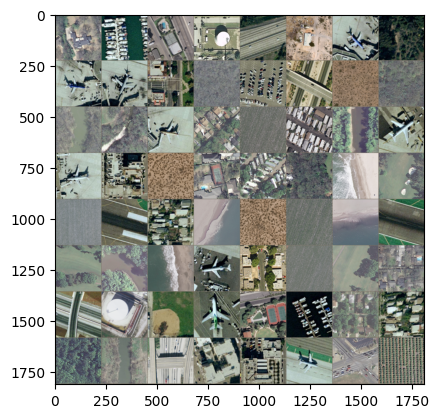

In [ ]:
#@title dataset

from torchvision.utils import make_grid

def matplotlib_imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(utils.IMAGENET_NORMALIZE["mean"])
    std = np.array(utils.IMAGENET_NORMALIZE["std"])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def get_fewshot_dataloader(n):
    dataset = FewShotImageFolder(
        root=ucmerced_dir,
        n_shots=n,
        transform=finetun_transform
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )

def test_fewshot_dataloader(n):
    dataloader = get_fewshot_dataloader(n)

    iterator = iter(dataloader)
    images, labels = next(iterator)

    img_grid = make_grid(images)
    matplotlib_imshow(img_grid)
    print([dataloader.dataset.classes[labels[i]] for i in range(len(labels))])
    plt.show()

test_fewshot_dataloader(1)
test_fewshot_dataloader(2)
test_fewshot_dataloader(5)
test_fewshot_dataloader(10)
test_fewshot_dataloader(20)

In [ ]:
#@title few-shot method

import copy
from collections import Counter
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import balanced_accuracy_score

def train_per_epoch(sampler, loss_fn, optim, model, freeze_backbone=False):
    model.train()

    if freeze_backbone:
        model.freeze_backbone(True)

    predictions = []
    targets = []
    avg_loss = 0.0
    i = 0
    for x, y in sampler:
        i += 1
        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()

        if torch.cuda.is_available():
            y_hat = nn.parallel.data_parallel(model, x)
        else:
            y_hat = model(x)

        loss = loss_fn(y_hat, y)
        avg_loss += loss.item()
        loss.backward()

        optim.step()

        _, predicted = torch.max(y_hat, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(y.cpu().numpy())

    if freeze_backbone:
        model.freeze_backbone(False)

    return (avg_loss / i, balanced_accuracy_score(targets, predictions))

def validate_per_epoch(loss_fn, model):
    model.eval()

    predictions = []
    targets = []
    avg_loss = 0.0
    i = 0
    with torch.no_grad():
        for (x, y) in finetun_test_dataloader:
            i += 1
            x = x.to(device)
            y = y.to(device)

            if torch.cuda.is_available():
                y_hat = nn.parallel.data_parallel(model, x)
            else:
                y_hat = model(x)

            loss = loss_fn(y_hat, y)
            avg_loss += loss.item()

            _, predicted = torch.max(y_hat, 1);
            predictions.extend(predicted.cpu().numpy())
            targets.extend(y.cpu().numpy())

    return (avg_loss / i, balanced_accuracy_score(targets, predictions))

def few_shot_train(
    n_shots,
    epochs,
    model,
    learning_rate=0.00625,
    backbone_freeze_interval=None,
    backbone_freeze_for=None,
    report_interval=5
):
    assert bool(backbone_freeze_interval) == bool(backbone_freeze_for), "backbone_freeze_interval and backbone_freeze_for are dependent"

    loss_fn = CrossEntropyLoss()
    optim = Adam(
        [
            { "params": model.backbone.parameters(), "lr": 1e-5, },
            { "params": model.imm_fc.parameters(), "lr": learning_rate, },
            { "params": model.out_fc.parameters(), "lr": learning_rate, },
        ],
        lr=learning_rate
    )

    history = {
        "tloss": [],
        "tacc": [],
        "vloss": [],
        "vacc": [],
    }
    i = 0
    freeze = False
    for e in range(epochs):
        sampler = get_fewshot_dataloader(n_shots)
        if not freeze and backbone_freeze_interval == i:
            i = 0
            freeze = True
        if freeze and backbone_freeze_for == i:
            i = 0
            freeze = False

        tloss, tacc = train_per_epoch(sampler, loss_fn, optim, model, freeze)
        history["tloss"].append(tloss)
        history["tacc"].append(tacc)

        vloss, vacc = validate_per_epoch(loss_fn, model)
        history["vloss"].append(vloss)
        history["vacc"].append(vacc)

        if (e + 1) % report_interval == 0:
            print(
                f"epoch {(e + 1):3d}: train loss = {tloss:.8f}"
                f" train accuracy = {tacc * 100:.2f}%"
                f" | validation loss = {vloss:.8f}"
                f" validation accuracy = {vacc * 100:.2f}%"
            )
        i += 1

    return history

fewshot_accuracy = {}


#### Pre-trained weights

In [ ]:
#@title 1-shot

lr = 0.005 # TODO: learning_rate decay
history = few_shot_train(1, 25, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["1-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"1-shot train accuracy: {fewshot_accuracy['1-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['1-shot']['validation']}"
)

epoch   1: train loss = 2.99629259 train accuracy = 14.29% | validation loss = 2.72772243 validation accuracy = 20.21%
epoch   2: train loss = 2.22514677 train accuracy = 33.33% | validation loss = 2.45999391 validation accuracy = 29.35%
epoch   3: train loss = 1.58049667 train accuracy = 71.43% | validation loss = 2.33504339 validation accuracy = 29.55%
epoch   4: train loss = 1.21445680 train accuracy = 76.19% | validation loss = 2.27791598 validation accuracy = 35.68%
epoch   5: train loss = 0.92050725 train accuracy = 80.95% | validation loss = 2.23888161 validation accuracy = 43.80%
epoch   6: train loss = 0.67596024 train accuracy = 95.24% | validation loss = 2.29169629 validation accuracy = 46.53%
epoch   7: train loss = 0.50042260 train accuracy = 100.00% | validation loss = 2.46200874 validation accuracy = 48.14%
epoch   8: train loss = 0.35928631 train accuracy = 100.00% | validation loss = 2.67289796 validation accuracy = 47.52%
epoch   9: train loss = 0.23829274 train accur

In [ ]:
#@title 2-shot

lr = 0.005
history = few_shot_train(2, 25, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["2-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"2-shot train accuracy: {fewshot_accuracy['2-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['2-shot']['validation']}"
)

epoch   1: train loss = 3.01179934 train accuracy = 9.52% | validation loss = 2.64869647 validation accuracy = 16.25%
epoch   2: train loss = 2.24086952 train accuracy = 33.33% | validation loss = 2.42193730 validation accuracy = 30.56%
epoch   3: train loss = 1.65963495 train accuracy = 76.19% | validation loss = 2.34184512 validation accuracy = 32.98%
epoch   4: train loss = 1.27105963 train accuracy = 80.95% | validation loss = 2.28036820 validation accuracy = 38.92%
epoch   5: train loss = 0.96489608 train accuracy = 85.71% | validation loss = 2.26493292 validation accuracy = 46.16%
epoch   6: train loss = 0.72119510 train accuracy = 90.48% | validation loss = 2.34548284 validation accuracy = 47.23%
epoch   7: train loss = 0.53664410 train accuracy = 92.86% | validation loss = 2.50392704 validation accuracy = 46.72%
epoch   8: train loss = 0.38979703 train accuracy = 97.62% | validation loss = 2.73463118 validation accuracy = 48.66%
epoch   9: train loss = 0.28142208 train accuracy

In [ ]:
#@title 5-shot

lr = 0.005
history = few_shot_train(5, 25, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["5-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"5-shot train accuracy: {fewshot_accuracy['5-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['5-shot']['validation']}"
)

epoch   1: train loss = 3.01447797 train accuracy = 5.71% | validation loss = 2.40927360 validation accuracy = 25.28%
epoch   2: train loss = 2.06406760 train accuracy = 40.00% | validation loss = 2.09520835 validation accuracy = 37.17%
epoch   3: train loss = 1.58562058 train accuracy = 62.86% | validation loss = 1.90850571 validation accuracy = 50.56%
epoch   4: train loss = 1.17529523 train accuracy = 76.19% | validation loss = 1.82795813 validation accuracy = 56.47%
epoch   5: train loss = 0.85575774 train accuracy = 90.48% | validation loss = 1.75778768 validation accuracy = 59.15%
epoch   6: train loss = 0.57328752 train accuracy = 90.48% | validation loss = 1.68254634 validation accuracy = 59.72%
epoch   7: train loss = 0.44655822 train accuracy = 90.48% | validation loss = 1.69042456 validation accuracy = 62.57%
epoch   8: train loss = 0.27241398 train accuracy = 97.14% | validation loss = 1.65651470 validation accuracy = 60.53%
epoch   9: train loss = 0.17993402 train accuracy

In [ ]:
#@title 10-shot

lr = 0.005
history = few_shot_train(10, 25, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["10-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"10-shot train accuracy: {fewshot_accuracy['10-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['10-shot']['validation']}"
)

epoch   1: train loss = 2.64571124 train accuracy = 17.62% | validation loss = 2.21273621 validation accuracy = 26.40%
epoch   2: train loss = 1.78431898 train accuracy = 50.00% | validation loss = 1.73374531 validation accuracy = 59.28%
epoch   3: train loss = 1.10006334 train accuracy = 76.19% | validation loss = 1.47587761 validation accuracy = 59.39%
epoch   4: train loss = 0.82951693 train accuracy = 84.29% | validation loss = 1.29088268 validation accuracy = 59.93%
epoch   5: train loss = 0.52621014 train accuracy = 83.33% | validation loss = 1.48935554 validation accuracy = 61.34%
epoch   6: train loss = 0.48815351 train accuracy = 89.52% | validation loss = 1.40002483 validation accuracy = 64.97%
epoch   7: train loss = 0.29868190 train accuracy = 92.38% | validation loss = 1.52756841 validation accuracy = 62.09%
epoch   8: train loss = 0.26637898 train accuracy = 96.67% | validation loss = 1.24669536 validation accuracy = 70.36%
epoch   9: train loss = 0.19261574 train accurac

In [ ]:
#@title 20-shot

lr = 0.005
history = few_shot_train(20, 25, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["20-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"20-shot train accuracy: {fewshot_accuracy['20-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['20-shot']['validation']}"
)

epoch   1: train loss = 2.49657478 train accuracy = 25.71% | validation loss = 1.83377930 validation accuracy = 44.97%
epoch   2: train loss = 1.38419752 train accuracy = 59.05% | validation loss = 1.21334603 validation accuracy = 60.20%
epoch   3: train loss = 0.61447718 train accuracy = 81.67% | validation loss = 1.06355124 validation accuracy = 61.77%
epoch   4: train loss = 0.43163641 train accuracy = 86.19% | validation loss = 1.02119067 validation accuracy = 65.36%
epoch   5: train loss = 0.29803608 train accuracy = 89.76% | validation loss = 0.78301568 validation accuracy = 73.63%
epoch   6: train loss = 0.17113938 train accuracy = 94.76% | validation loss = 0.76592004 validation accuracy = 76.23%
epoch   7: train loss = 0.13588456 train accuracy = 96.67% | validation loss = 0.83210538 validation accuracy = 72.81%
epoch   8: train loss = 0.12145410 train accuracy = 97.14% | validation loss = 0.90258366 validation accuracy = 73.83%
epoch   9: train loss = 0.11235706 train accurac

In [ ]:
def full_train(
    epochs,
    dataloader,
    model,
    learning_rate=0.00625,
    backbone_freeze_interval=None,
    backbone_freeze_for=None,
    report_interval=5
):
    loss_fn = CrossEntropyLoss()
    optim = Adam(
        [
            { "params": model.backbone.parameters(), "lr": 1e-5, },
            { "params": model.imm_fc.parameters(), "lr": learning_rate, },
            { "params": model.out_fc.parameters(), "lr": learning_rate, },
        ],
        lr=learning_rate
    )

    history = {
        "tloss": [],
        "tacc": [],
        "vloss": [],
        "vacc": [],
    }
    i = 0
    freeze = False
    for e in range(epochs):
        if not freeze and backbone_freeze_interval == i:
            i = 0
            freeze = True
        if freeze and backbone_freeze_for == i:
            i = 0
            freeze = False

        tloss, tacc = train_per_epoch(dataloader, loss_fn, optim, model, freeze)
        history["tloss"].append(tloss)
        history["tacc"].append(tacc)

        vloss, vacc = validate_per_epoch(loss_fn, model)
        history["vloss"].append(vloss)
        history["vacc"].append(vacc)

        if (e + 1) % report_interval == 0:
            print(
                f"epoch {(e + 1):3d}: train loss = {tloss:.8f}"
                f" train accuracy = {tacc * 100:.2f}%"
                f" | validation loss = {vloss:.8f}"
                f" validation accuracy = {vacc * 100:.2f}%"
            )
        i += 1

    return history, model

fewshot_accuracy = {}

lr = 0.005
history, model = full_train(10, pretrain_dataloader, copy.deepcopy(finetun_model), lr, 5, 5, 1)
fewshot_accuracy["20-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"20-shot train accuracy: {fewshot_accuracy['20-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['20-shot']['validation']}"
)

epoch   1: train loss = 1.52464991 train accuracy = 51.41% | validation loss = 0.59453593 validation accuracy = 80.33%
epoch   2: train loss = 0.56654788 train accuracy = 80.31% | validation loss = 0.39037183 validation accuracy = 85.43%
epoch   3: train loss = 0.39508774 train accuracy = 85.78% | validation loss = 0.31462783 validation accuracy = 86.89%
epoch   4: train loss = 0.30103782 train accuracy = 88.68% | validation loss = 0.17365574 validation accuracy = 94.20%
epoch   5: train loss = 0.26513542 train accuracy = 91.02% | validation loss = 0.20287545 validation accuracy = 90.95%
epoch   6: train loss = 0.20040112 train accuracy = 92.58% | validation loss = 0.17649064 validation accuracy = 93.03%
epoch   7: train loss = 0.19169973 train accuracy = 93.40% | validation loss = 0.10091530 validation accuracy = 96.31%
epoch   8: train loss = 0.16197010 train accuracy = 94.87% | validation loss = 0.07998538 validation accuracy = 97.50%
epoch   9: train loss = 0.12477658 train accurac

#### Raw model

In [ ]:
#@title initialize with randomized backbone weights

resnet18 = models.resnet18()
backbone = nn.Sequential(*list(resnet18.children())[:-1])

raw_fewshot_accuracy = {}

raw_model = FineTuningSimSiam(backbone, n_classes)
raw_model.to(device)

FineTuningSimSiam(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
#@title 1-shot

lr = 0.005
history = few_shot_train(1, 25, copy.deepcopy(raw_model), lr, 5, 5)
raw_fewshot_accuracy["1-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"1-shot train accuracy: {raw_fewshot_accuracy['1-shot']['train']}"
    f" | validation accuracy: {raw_fewshot_accuracy['1-shot']['validation']}"
)

epoch   5: train loss = 2.31628585 train accuracy = 71.43% | validation loss = 2.97311695 validation accuracy = 8.18%
epoch  10: train loss = 1.35281742 train accuracy = 90.48% | validation loss = 3.34818041 validation accuracy = 7.90%
epoch  15: train loss = 0.68605506 train accuracy = 100.00% | validation loss = 4.25003662 validation accuracy = 7.20%
epoch  20: train loss = 0.22188680 train accuracy = 100.00% | validation loss = 5.18496547 validation accuracy = 8.04%
epoch  25: train loss = 0.07086107 train accuracy = 100.00% | validation loss = 5.74463515 validation accuracy = 8.54%
1-shot train accuracy: 1.0 | validation accuracy: 0.096991896991897


In [ ]:
#@title 2-shot

lr = 0.005
history = few_shot_train(2, 25, copy.deepcopy(raw_model), lr, 5, 5, 1)
raw_fewshot_accuracy["2-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"2-shot train accuracy: {raw_fewshot_accuracy['2-shot']['train']}"
    f" | validation accuracy: {raw_fewshot_accuracy['2-shot']['validation']}"
)

epoch   1: train loss = 3.03092766 train accuracy = 4.76% | validation loss = 3.15541382 validation accuracy = 4.76%
epoch   2: train loss = 2.93677449 train accuracy = 7.14% | validation loss = 2.99739759 validation accuracy = 6.11%
epoch   3: train loss = 2.74885297 train accuracy = 23.81% | validation loss = 2.97566657 validation accuracy = 8.77%
epoch   4: train loss = 2.55504036 train accuracy = 30.95% | validation loss = 2.97084057 validation accuracy = 10.28%
epoch   5: train loss = 2.36124396 train accuracy = 38.10% | validation loss = 2.97763705 validation accuracy = 10.62%
epoch   6: train loss = 2.17911816 train accuracy = 42.86% | validation loss = 3.01018853 validation accuracy = 9.89%
epoch   7: train loss = 2.01520801 train accuracy = 59.52% | validation loss = 3.06597264 validation accuracy = 7.22%
epoch   8: train loss = 1.84081686 train accuracy = 76.19% | validation loss = 3.15739226 validation accuracy = 6.65%
epoch   9: train loss = 1.68676782 train accuracy = 80.9

In [ ]:
#@title 5-shot

lr = 0.005
history = few_shot_train(5, 25, copy.deepcopy(raw_model), lr, 5, 5, 1)
raw_fewshot_accuracy["5-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"5-shot train accuracy: {raw_fewshot_accuracy['5-shot']['train']}"
    f" | validation accuracy: {raw_fewshot_accuracy['5-shot']['validation']}"
)

epoch   1: train loss = 3.44072998 train accuracy = 3.81% | validation loss = 2.98285742 validation accuracy = 8.40%
epoch   2: train loss = 2.94114220 train accuracy = 13.33% | validation loss = 3.00503600 validation accuracy = 9.34%
epoch   3: train loss = 2.83210659 train accuracy = 14.29% | validation loss = 3.02074337 validation accuracy = 7.51%
epoch   4: train loss = 2.68829811 train accuracy = 17.14% | validation loss = 3.05867441 validation accuracy = 7.10%
epoch   5: train loss = 2.61131036 train accuracy = 28.57% | validation loss = 3.11891124 validation accuracy = 7.84%
epoch   6: train loss = 2.50212967 train accuracy = 27.62% | validation loss = 3.20155053 validation accuracy = 6.53%
epoch   7: train loss = 2.27733600 train accuracy = 39.05% | validation loss = 3.23787303 validation accuracy = 7.20%
epoch   8: train loss = 2.21034098 train accuracy = 44.76% | validation loss = 3.25593550 validation accuracy = 7.01%
epoch   9: train loss = 2.07473290 train accuracy = 43.81

In [ ]:
#@title 10-shot

lr = 0.005
history = few_shot_train(10, 25, copy.deepcopy(raw_model), lr, 5, 5, 1)
raw_fewshot_accuracy["10-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"10-shot train accuracy: {raw_fewshot_accuracy['10-shot']['train']}"
    f" | validation accuracy: {raw_fewshot_accuracy['10-shot']['validation']}"
)

epoch   1: train loss = 3.28598332 train accuracy = 3.81% | validation loss = 3.03044300 validation accuracy = 8.50%
epoch   2: train loss = 2.89844298 train accuracy = 14.29% | validation loss = 3.03184304 validation accuracy = 6.85%
epoch   3: train loss = 2.81107366 train accuracy = 11.90% | validation loss = 3.11641743 validation accuracy = 4.76%
epoch   4: train loss = 2.58175635 train accuracy = 16.19% | validation loss = 3.19215052 validation accuracy = 5.18%
epoch   5: train loss = 2.45617372 train accuracy = 18.57% | validation loss = 3.11751101 validation accuracy = 6.35%
epoch   6: train loss = 2.35409147 train accuracy = 20.00% | validation loss = 3.35313976 validation accuracy = 8.56%
epoch   7: train loss = 2.21635139 train accuracy = 21.90% | validation loss = 3.47576993 validation accuracy = 5.72%
epoch   8: train loss = 2.09018627 train accuracy = 30.00% | validation loss = 3.24123387 validation accuracy = 10.49%
epoch   9: train loss = 2.02185789 train accuracy = 28.5

In [ ]:
#@title 20-shot

lr = 0.005
history = few_shot_train(20, 25, copy.deepcopy(raw_model), lr, 5, 5, 1)
raw_fewshot_accuracy["20-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"20-shot train accuracy: {raw_fewshot_accuracy['20-shot']['train']}"
    f" | validation accuracy: {raw_fewshot_accuracy['20-shot']['validation']}"
)

epoch   1: train loss = 3.22665201 train accuracy = 5.24% | validation loss = 3.04840462 validation accuracy = 4.80%
epoch   2: train loss = 2.82304628 train accuracy = 11.67% | validation loss = 3.06606805 validation accuracy = 4.76%
epoch   3: train loss = 2.60952139 train accuracy = 16.43% | validation loss = 3.25257406 validation accuracy = 5.49%
epoch   4: train loss = 2.44516659 train accuracy = 23.33% | validation loss = 3.00571167 validation accuracy = 12.98%
epoch   5: train loss = 2.32700893 train accuracy = 23.10% | validation loss = 2.97669282 validation accuracy = 12.27%
epoch   6: train loss = 2.07144056 train accuracy = 34.76% | validation loss = 2.79200892 validation accuracy = 22.24%
epoch   7: train loss = 1.81141215 train accuracy = 45.48% | validation loss = 2.90054545 validation accuracy = 20.01%
epoch   8: train loss = 1.66773043 train accuracy = 45.71% | validation loss = 2.71124115 validation accuracy = 26.10%
epoch   9: train loss = 1.49031230 train accuracy = 

In [ ]:
lr = 0.005
history, model = full_train(20, pretrain_dataloader, copy.deepcopy(raw_model), lr, 5, 5, 1)
fewshot_accuracy["20-shot"] = {"train": max(history["tacc"]), "validation": max(history["vacc"])}
print(
    f"20-shot train accuracy: {fewshot_accuracy['20-shot']['train']}"
    f" | validation accuracy: {fewshot_accuracy['20-shot']['validation']}"
)

epoch   1: train loss = 2.91396327 train accuracy = 10.56% | validation loss = 2.71079421 validation accuracy = 14.06%
epoch   2: train loss = 2.57166977 train accuracy = 18.68% | validation loss = 2.35479219 validation accuracy = 23.85%
epoch   3: train loss = 2.31466976 train accuracy = 25.36% | validation loss = 2.06912950 validation accuracy = 28.83%
epoch   4: train loss = 2.18963788 train accuracy = 28.22% | validation loss = 2.10917135 validation accuracy = 31.35%
epoch   5: train loss = 1.99176092 train accuracy = 33.42% | validation loss = 1.79198517 validation accuracy = 39.01%
epoch   6: train loss = 1.90131515 train accuracy = 36.06% | validation loss = 1.70622827 validation accuracy = 39.43%
epoch   7: train loss = 1.85866645 train accuracy = 38.10% | validation loss = 1.71214463 validation accuracy = 38.72%
epoch   8: train loss = 1.76851844 train accuracy = 39.93% | validation loss = 1.66694536 validation accuracy = 44.70%
epoch   9: train loss = 1.72348814 train accurac

### Testing

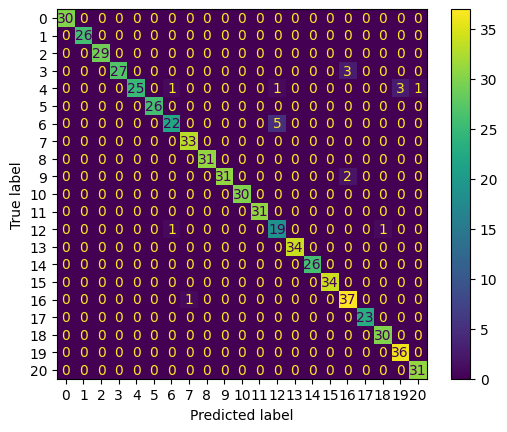

In [ ]:
#@title confusion matrix finetuned model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def make_confusion_matrix(model):
    true_labels = []
    predicted_labels = []
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(finetun_test_dataloader):
            x = x.to(device)
            y = y.to(device)
            if torch.cuda.is_available():
                y_hat = nn.parallel.data_parallel(model, x)
            else:
                y_hat = model(x)

            _, predicted = torch.max(y_hat, 1)
            true_labels.extend(y.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return confusion_matrix(true_labels, predicted_labels)

cm = make_confusion_matrix(model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
disp.plot()
plt.show()

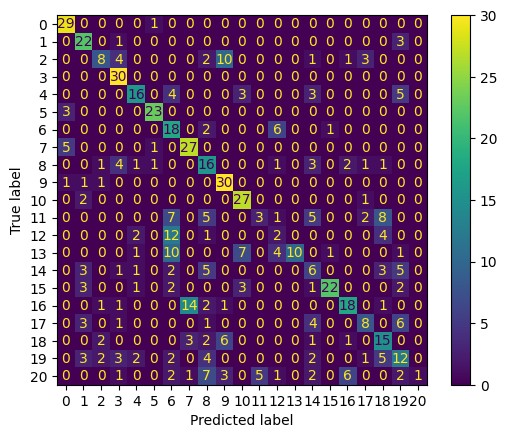

In [ ]:
cm = make_confusion_matrix(model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
disp.plot()
plt.show()

In [ ]:
#@title save results

torch.save(
    finetun_model.state_dict(),
    os.path.join(pibic_dir, "runs/UCMerced/ucmerced_finetuned_simsiam_last.pth")
)

df = pd.DataFrame(raw_fewshot_accuracy)
df.to_excel(os.path.join(pibic_dir, "runs/UCMerced/raw_fewshot_accuracy.xlsx"))

df = pd.DataFrame(fewshot_accuracy)
df.to_excel(os.path.join(pibic_dir, "runs/UCMerced/fewshot_accuracy.xlsx"))
df

1-shot    2-shot    5-shot   10-shot   20-shot
train       1.000000  1.000000  1.000000  1.000000  1.000000
validation  0.414706  0.504393  0.655791  0.731528  0.793128